# Проверка гипотез для увеличения выручки интернет-магазина

# Содержание
**1 [Загружаем данные и готовим их к анализу](#1)**

**2 [Приоритизация гипотез](#2)**

**3 [Анализ A/B-теста](#3)**

**3.1 [Создаем таблицы для оценки кумулятивных метрик](#31)**

**3.2 [Строим график кумулятивной выручки по группам](#32)**

**3.3 [Строим график кумулятивного среднего чека по группам](#33)**

**3.4 [Строим график относительного изменения кумулятивного среднего чека группы B к группе A](#34)**

**3.5 [Строим график кумулятивной конверсии по группам](#35)**

**3.6 [Строим график относительного изменения кумулятивной конверсии группы B к группе А](#36)**

**3.7 [Строим точечный график количества заказов по пользователям](#37)**

**3.8 [Считаем 95-й и 99-й перцентили количества заказов на пользователя](#38)**

**3.9 [Строим точечный график стоимостей заказов](#39)**

**3.10 [Считаем 95-й и 99-й перцентили стоимости заказов](#310)**

**3.11 [Считаем статистическую значимость различий в конверсии между группами по «сырым» данным](#311)**

**3.12 [Считаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным](#312)**

**3.13 [Считаем статистическую значимость различий в конверсии между группами по «очищенным» данным](#313)**

**3.14 [Считаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным](#314)**

**4 [Выводы](#4)**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime as dt
import numpy as np
import scipy.stats as stats

<a id='1'></a>
##  Загружаем данные и готовим их к анализу

In [2]:
hypothesis=pd.read_csv('/datasets/hypothesis.csv')
orders=pd.read_csv('/datasets/orders.csv')
visitors=pd.read_csv('/datasets/visitors.csv')

Исходя из предшествующего опыта, наиболее частые недочеты при составлении таблиц: заглавные буквы и пробелы в названии столбцов, создадим функцию, которая будет исправлять эти недочеты, подсчитывать количество явных дубликатов и выводить первые 5 строк таблицы и информацию о ней. 

In [3]:
def start(x):
    x.columns=x.columns.str.lower()
    x.columns.str.replace(" ", "_")
    return display(x.head()), print(x.info()), x.duplicated().sum()

In [4]:
start(hypothesis)

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
None


(None, None, 0)

In [5]:
start(orders)

,transactionid,visitorid,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionid  1197 non-null   int64 
 1   visitorid      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
None


(None, None, 0)

В название столбцов с id лучше добавить нижнее подчеркивание.  

In [6]:
orders= orders.rename(columns={'transactionid': 'transaction_id', 'visitorid': 'visitor_id'})


In [7]:
start(visitors)


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
None


(None, None, 0)

Cтолбцы переименованы, дубликаты не найдены. Приведем значения столбцов с дата к типу 'datetime'.

In [8]:
orders['date']=orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors['date']=visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
print(orders.info())
print(visitors.info())            

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB
None


In [9]:
print(visitors['group'].unique())
print(orders['group'].unique())

['A' 'B']
['B' 'A']


Скрытых дубликатов в столбцах с обозначением групп нет. 

In [10]:
a=orders.groupby('visitor_id', as_index=False).agg({'group': 'nunique'}).sort_values(by='group', ascending=False).query('group>1')
print('Количество пользователей, включенных одновременно в обе группы =', a['visitor_id'].count())

Количество пользователей, включенных одновременно в обе группы = 58


In [11]:

print('Удаляем пользователей, входящих в обе группы:')
a=a['visitor_id']

orders=orders.query('visitor_id not in @a')
orders.info()

Удаляем пользователей, входящих в обе группы:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1016 non-null   int64         
 1   visitor_id      1016 non-null   int64         
 2   date            1016 non-null   datetime64[ns]
 3   revenue         1016 non-null   int64         
 4   group           1016 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 47.6+ KB


<a id='2'></a>
##  Приоритизация гипотез

Для приоретизации гипотез расчитаем ICE score и RICE score, добавим соответствующие столбцы в таблицу с данными о гипотезах. 

In [12]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [13]:
hypothesis['ice']=hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts']
hypothesis['rice']=hypothesis['impact']*hypothesis['confidence']*hypothesis['reach']/hypothesis['efforts']

In [14]:
display(hypothesis)
display(hypothesis[['hypothesis', 'ice']].sort_values(by='ice', ascending=False))
display(hypothesis[['hypothesis', 'rice']].sort_values(by='rice', ascending=False))

,hypothesis,reach,impact,confidence,efforts,ice,rice
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6,13.333333,40.0
1,"Запустить собственную службу доставки, что сок...",2,5,4,10,2.000000,4.0
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3,7.000000,56.0
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8,1.125000,9.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1,1.000000,3.0
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3,1.333333,4.0
6,Показать на главной странице баннеры с актуаль...,5,3,8,3,8.000000,40.0
7,Добавить форму подписки на все основные страни...,10,7,8,5,11.200000,112.0
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5,16.200000,16.2


,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день...",16.200000
0,"Добавить два новых канала привлечения трафика,...",13.333333
7,Добавить форму подписки на все основные страни...,11.200000
6,Показать на главной странице баннеры с актуаль...,8.000000
2,Добавить блоки рекомендаций товаров на сайт ин...,7.000000
1,"Запустить собственную службу доставки, что сок...",2.000000
5,"Добавить страницу отзывов клиентов о магазине,...",1.333333
3,"Изменить структура категорий, что увеличит кон...",1.125000
4,"Изменить цвет фона главной страницы, чтобы уве...",1.000000


,hypothesis,rice
7,Добавить форму подписки на все основные страни...,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,56.0
0,"Добавить два новых канала привлечения трафика,...",40.0
6,Показать на главной странице баннеры с актуаль...,40.0
8,"Запустить акцию, дающую скидку на товар в день...",16.2
3,"Изменить структура категорий, что увеличит кон...",9.0
1,"Запустить собственную службу доставки, что сок...",4.0
5,"Добавить страницу отзывов клиентов о магазине,...",4.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3.0


**Вывод:** Перспективными по шкале ICE гипотезами являются 8, 0, 7. По шкале RICE на первом месте оказывается 7 гипотеза, так как она охватывает максимальное количество пользователей. Далее идут гипотезы 2, 0, 6. В первую очередь следует проверить гипотезы 7 и 0, которые входят в первые три ранга по обеим шкалам. 

<a id='3'></a>
##  Анализ A/B-теста

<a id='31'></a>
###  Создаем таблицы для оценки кумулятивных метрик

In [15]:
# Создаем датафрейм datesGroups с уникальными парами значений 'date' и 'group', таблицы orders. 
# Избавляемся от дубликатов 

datesGroups = orders[['date','group']].drop_duplicates() 

# Создаем таблицу ordersAggregated, содержащую дату, группу A/B-теста, число уникальных заказов в группе теста 
# число уникальных пользователей, совершивших хотя бы 1 заказ в группе теста;
#суммарную выручку заказов в группе теста, ограничим даты анализа. 

ordersAggregated = datesGroups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({
'date' : 'max',
'group' : 'max',
'transaction_id' : pd.Series.nunique,
'visitor_id' : pd.Series.nunique,
'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# Создаем таблицу visitorsAggregated, содержащую дату, группу A/B-теста, количество уникальных посетителей 
# в группе теста по указанную дату включительно.

visitorsAggregated = (datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], 
                                                                         visitors['group'] == x['group'])]
                                       .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1)
                                       .sort_values(by=['date','group'])) 

# объединяем ordersAggregated и visitorsAggregated по колонкам 'date', 'group' методом merge() 
# в переменную cumulativeData

cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])

cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

# объявляем переменные в которых сохраняем данные по группам

cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB= cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

<a id='32'></a>
### Строим график кумулятивной выручки по группам

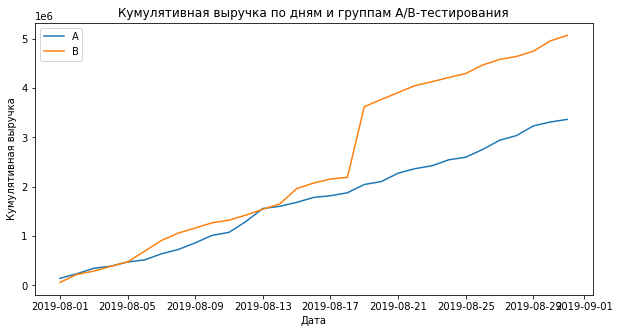

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.grid=True
plt.xlabel('Дата') 
plt.ylabel('Кумулятивная выручка') 
plt.title('Кумулятивная выручка по дням и группам A/B-тестирования')
plt.legend()
plt.show()

**Вывод:** Выручка увеличивается в течение всего теста - это хорошо. График выручки в **группе A** в течение всего теста увеличивается относительно равномерно. График выручки в **группе B** резко возрастает 17 августа, это может быть связано с резким увеличением числа заказов или  о появлении очень дорогих заказов в выборке. 

<a id='33'></a>
### Строим график кумулятивного среднего чека по группам

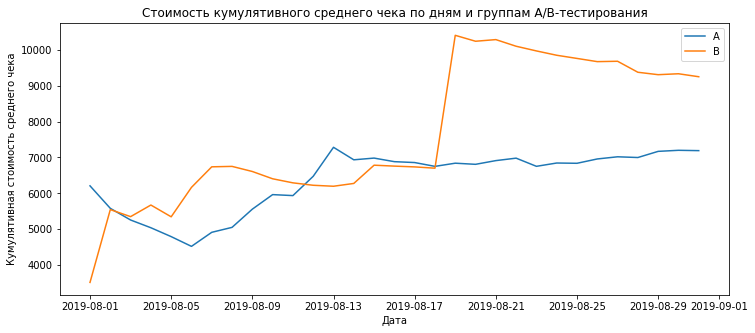

In [17]:
plt.figure(figsize=(12, 5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.grid=True
plt.xlabel('Дата') 
plt.ylabel('Кумулятивная стоимость среднего чека') 
plt.title('Стоимость кумулятивного среднего чека по дням и группам A/B-тестирования')
plt.legend()
plt.show()


**Вывод:** Средний чек растет с начала до середины теста. 17 августа мы видим резкое увеличение стоимости среднего чека  в **группе B** - вероятно в это время значительно увеличивается стоимость покупок, в дальнейшем средний чек незначительно снижается, при этом средний чек за период наблюдения так и не устанавливается на одном уровне. В **группе А** так же заметен подъем стоимости среднего чека в районе 13 августа, но подъем не настолько значительный, как в группе В, и сразу же снижается, что скорее всего связано с появлением дорогих покупок в этот период.  Для **группы A** средний чек  увеличивается ближе к концу периода наблюдения и можно предположить его стабилизацию в период с 29 августа.  

<a id='34'></a>
### Строим  график относительного изменения кумулятивного среднего чека группы B к группе A

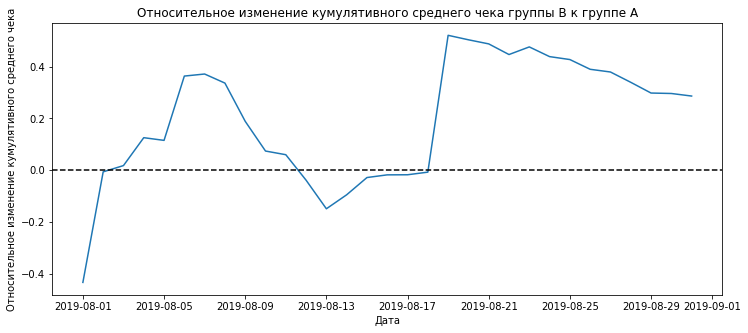

In [18]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(12, 5))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.axhline(y=0, color='black', linestyle='--') 
plt.grid=True
plt.xlabel('Дата') 
plt.ylabel('Относительное изменение кумулятивного среднего чека') 
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
plt.show()

**Выводы:** В нескольких точках график различия между сегментами резко «скачет». Можно предположить наличие крупных заказов и выбросов. 

<a id='35'></a>
### Строим график кумулятивной конверсии по группам

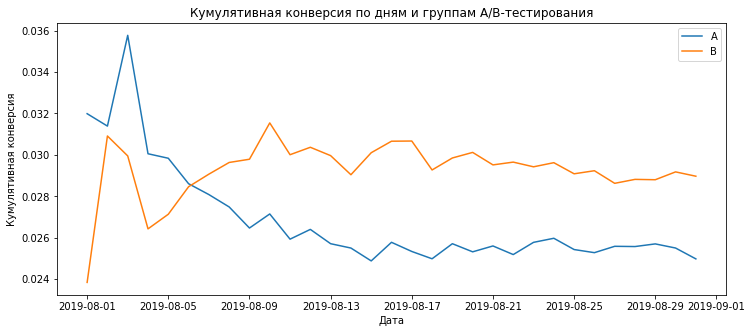

In [19]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.figure(figsize=(12, 5))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.xlabel('Дата') 
plt.ylabel('Кумулятивная конверсия') 
plt.title('Кумулятивная конверсия по дням и группам A/B-тестирования')
plt.legend()
plt.show()
# задаем масштаб осей



**Вывод** График сложно назвать симметричным. Конверсия в **группе А** снижается на протяжении всего периода наблюдения, а на графике конверсии в **группе B** в начале исследования мы видим резкое кратковременное падение, а затем рост конверсии с последующим незначительным снижением. 

<a id='36'></a>
### Строим график относительного изменения кумулятивной конверсии группы B к группе А

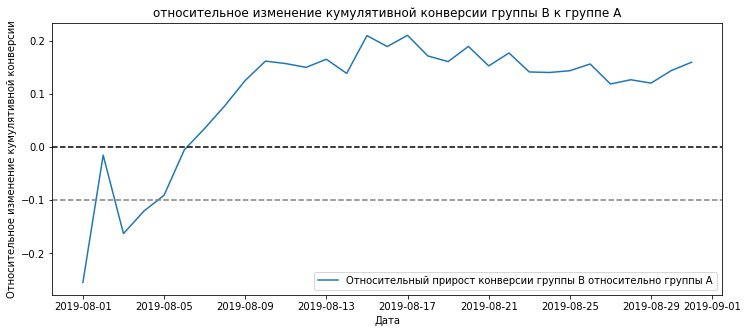

In [20]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(12, 5))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.xlabel('Дата') 
plt.ylabel('Относительное изменение кумулятивной конверсии') 
plt.title('относительное изменение кумулятивной конверсии группы B к группе А')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
#plt.axis(["2019-04-01", '2019-04-23', -0.6, 0.6]) 
plt.legend()
plt.show()


**Вывод:** В начале теста **группа B** значительно проигрывала **группе A**, затем вырвалась вперёд и в дальнейшем ниже конверсии в группе А не устанавливалась. 

<div class="alert alert-success">
<h2> Комментарий ревьюера<a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
    
Графики выглядят корректно, согласна с интерпретацией визуализации.

<a id='37'></a>
### Строим точечный график количества заказов по пользователям

     visitor_id  orders
908  3967698036       3
55    249864742       3
478  2108163459       3
687  2988190573       3
890  3908431265       3
138   611059232       3
632  2742574263       3
157   678354126       2
323  1404560065       2
452  1985475298       2


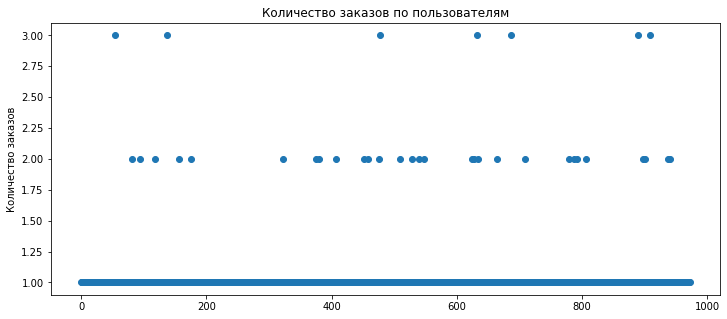

In [21]:


ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)

ordersByUsers.columns = ['visitor_id', 'orders']

print(ordersByUsers.sort_values(by='orders', ascending=False).head(10)) 


x_values = pd.Series(range(0,len(ordersByUsers)))
plt.figure(figsize=(12, 5))
plt.scatter(x_values, ordersByUsers['orders']) 
plt.ylabel('Количество заказов') 
plt.title('Количество заказов по пользователям')
plt.show()

**Выводы:** Мы видим много пользователей с 2-4 заказами. Их точная доля не ясна — непонятно, считать их аномалиями или нет. 

<a id='38'></a>
### Считаем 95-й и 99-й перцентили количества заказов на пользователя

In [22]:

print(np.percentile(ordersByUsers['orders'], [ 95, 99])) 

[1. 2.]


**Вывод** Не более 5% пользователей осуществляют более 2 покупок. Более 2, но менее 4 покупок осуществляют всего 4% пользователей.  Таким образом 2 заказа на одного пользователя принимаем за  границу числа заказов.

<a id='39'></a>
### Строим точечный график стоимостей заказов

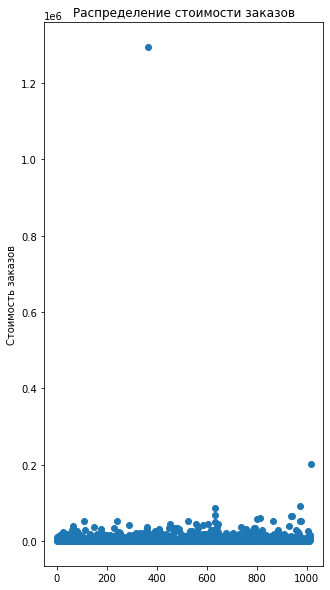

In [23]:
x_values = pd.Series(range(0,len(orders['revenue'])))

plt.figure(figsize=(5, 10))
plt.scatter(x_values, orders['revenue'])
plt.ylabel('Стоимость заказов') 
plt.title('Распределение стоимости заказов')
plt.show()


При построении графика возникли проблемы, максимальная выручка заказа превышает 1,2 млн. Следующее выпадающее значение на уровне 200 тысяч. 
Ограничим ось Y максимальным значением в 250 тысяч и посмотрим, что получилось. 

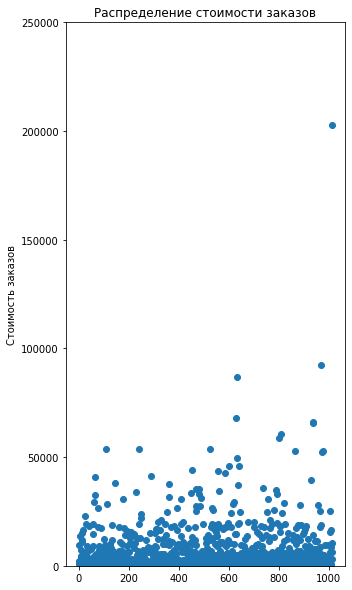

In [24]:
x_values = pd.Series(range(0,len(orders['revenue'])))

plt.figure(figsize=(5, 10))
plt.scatter(x_values, orders['revenue'])
plt.ylabel('Стоимость заказов') 
plt.title('Распределение стоимости заказов')
plt.ylim((0,250000))
plt.show()

Теперь мы видим, что выручка большинства заказов находится в пределах 25000. 

<a id='310'></a>
### Считаем 95-й и 99-й перцентили стоимости заказов

In [25]:
print(np.percentile(orders['revenue'], [95, 99])) 

[26785. 53904.]


**Вывод:**  Выручка 95% заказов не превышает 28000, выручка 99% заказов не превышает 58234. 28000 принимаем за  границу выручки с заказа.

<a id='311'></a>
### Считаем статистическую значимость различий в конверсии между группами по «сырым» данным 

Сформулируем гипотезы:

**Нулевая:** Различий в конверсии между группами нет. 

**Альтернативная:** различия в конверсии между группами есть.

In [26]:
#подготовим данные для анализа
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitor_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitor_id', 'orders'] 

#Объявляем переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать 
#количество заказов, для пользователей, которые ничего не заказали количество заказов будет равно 0.  
sampleA = pd.concat([ordersByUsersA['orders'],
                      pd.Series(0, index=np.arange(data['visitorsPerDateA']
                      .sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],
                      pd.Series(0, index=np.arange(data['visitorsPerDateB']
                      .sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

#Теперь выборки готовы к проверке критерием Манна-Уитни.


In [27]:
print('p-value='"{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print('относительные различия в конверсии: '"{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

p-value=0.011
относительные различия в конверсии: 0.160


**Вывод:** p-value = 0.017, что меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем. Oтносительный выигрыш группы B равен 13,8% — второе число в выводе.  

<a id='312'></a>
### Считаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным

Сформулируем гипотезы:

**Нулевая гипотеза:** различий в среднем чеке между группами нет. 

**Альтернативная гипотеза:** различия в среднем чеке между группами есть. 

In [28]:
#передадим критерию mannwhitneyu() данные о выручке с заказов
print('p-value='"{0:.3f}".format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
#найдём относительные различия в среднем чеке между группами
print('относительные различия в среднем чеке: '"{0:.3f}".format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

p-value=0.829
относительные различия в среднем чеке: 0.287


**Вывод:** p-value = 0.729, что больше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, не отвергаем. Но при этом относительный выигрыш группы B равен 25,9% — второе число в выводе.

<a id='313'></a>
### Считаем статистическую значимость различий в конверсии между группами по «очищенным» данным

In [29]:
#посчитаем сколько всего аномальных пользователей (границы выявили раньше - более 2 заказов и выручка более 28000)
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['visitor_id'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['visitor_id'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

print('Количество аномальных пользователей:' , abnormalUsers.shape[0]) 

Количество аномальных пользователей: 55


In [30]:
# очистим данные 
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

In [31]:
print('p-value='"{0:.3f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('относительные различия конверсии: '"{0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

p-value=0.009
относительные различия конверсии: 0.189


**Вывод:** p-value = 0.013, что меньше 0.05. Результаты по конверсии практически не изменились. 

<a id='314'></a>
### Считаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным

In [32]:
print('p-value='
    "{0:.3f}".format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print('относительные различия в среднем чеке: '"{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

p-value=0.762
относительные различия в среднем чеке: -0.022


**Вывод:** p-value = 0.738, что больше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, не отвергаем. Но при этом относительная разница выручки среднего чека группы B снизился до  -2% — второе число в выводе.

<a id='4'></a>
## Выводы

**Имеющиеся факты:**

1. Есть статистически значимое различие по конверсии между группами как по сырым данным, так и после фильтрации аномалий.
2. По сырым и очищенным данным нет статистически значимого различия выручки по среднему чеку между группами.    
3. График различия конверсии между группами сообщает, что результаты группы B лучше группы A: имеют тенденцию к росту.
4. График различия выручки среднего чека колеблется: это позволило нам найти аномалии. Сделать из этого графика определённые выводы нельзя.


   

**Вывод: Следует остановить тест, признать его неуспешным. Несмотря на достоверные различия в конверсии, основной целью исследования является увеличение выручки, а достоверных различий по этому показателю ни по сырым, ни по очищенным данным не наблюдается.**